In [1]:
import io
import math

import torch
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import datasets, train, models, utils

import pytorch_lightning as pl

from compressai.zoo import bmshj2018_hyperprior

from copy import deepcopy

In [2]:
def pillow_encode(img, fmt='jpeg', quality=10):
    tmp = io.BytesIO()
    img.save(tmp, format=fmt, quality=quality)
    tmp.seek(0)
    filesize = tmp.getbuffer().nbytes
    bpp = filesize * float(8) / (img.size[0] * img.size[1])
    rec = Image.open(tmp)
    return rec, bpp

In [3]:
def find_closest_bpp(target, img, fmt='jpeg'):
    lower = 0
    upper = 100
    prev_mid = upper
    for i in range(10):
        mid = (upper - lower) / 2 + lower
        if int(mid) == int(prev_mid):
            break
        rec, bpp = pillow_encode(img, fmt=fmt, quality=int(mid))
        if bpp > target:
            upper = mid - 1
        else:
            lower = mid
    return rec, bpp
    
def mse(a, b):
    a = np.asarray(a).astype(np.float32)
    b = np.asarray(b).astype(np.float32)
    return np.mean(np.square(a - b))

def psnr(a, b, max_value=255):
        return psnr_from_mse(mse(a, b, max_value))
    
def psnr_from_mse(mse, max_value=255):
        return 20 * math.log10(max_value) - 10. * math.log10(mse)

In [4]:
def compare_with_classical(rec_net, original_image, target_bpp):
    rec_jpeg, bpp_jpeg = find_closest_bpp(target_bpp, original_image, fmt="jpeg")
    rec_webp, bpp_webp = find_closest_bpp(target_bpp, original_image, fmt='webp')

    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    for ax in axes.ravel():
        ax.axis('off')

    fig.title = 'yolo'
    axes[0][0].imshow(original_image)
    axes[0][0].title.set_text('Original')
    axes[0][1].imshow(rec_net)
    axes[0][1].title.set_text(f'Net {target_bpp:.3f} bpp, {mse(rec_net, original_image):.2f} mse')
    axes[1][0].imshow(rec_jpeg)
    axes[1][0].title.set_text(f'JPEG {bpp_jpeg:.3f} bpp, {mse(rec_jpeg, original_image):.2f} mse')
    axes[1][1].imshow(rec_webp)
    axes[1][1].title.set_text(f'WebP {bpp_webp:.3f} bpp, {mse(rec_webp, original_image):.2f} mse')

    plt.show()

In [5]:
def get_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

def compute_bpp(likelihoods, num_pixels):
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
          for like in likelihoods).item()

In [6]:
def run_pretrained_model(image, model, quality, verbose=True):
    device = 'cpu'

    net = model(quality=quality, pretrained=True).eval().to(device)

    if type(image) == torch.Tensor:
        x = image
    else:
        x = transforms.ToTensor()(image).unsqueeze(0).to(device)

    with torch.no_grad():
        out_net = net.forward(x)
    
    out_net['x_hat'].clamp_(0, 1)

    if type(image) == torch.Tensor:
        rec_net = out_net['x_hat'].squeeze().cpu()
    else:
        rec_net = transforms.ToPILImage()(out_net['x_hat'].squeeze().cpu())
    
    if verbose:
        print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

    return get_bpp(out_net), rec_net

In [7]:
def mse_across_tasks(batch, model):
    """
    We want to return an list of mse and bpp values for each task
    """
    
    ans = {key: {"mse": list(), "bpp": list()} for key in batch.keys()}


    # for all tasks
    for task, image_tensors in batch.items():
        # for all bpp values
        
        if model in ("JPEG", "WEBP"):
            for bpp in (0.2, 0.5, 0.8, 1):        

                batch_bpps = []
                batch_mses = []

                # for all images of the task in a batch
                for image_tensor in image_tensors:

                    image = transforms.ToPILImage()(image_tensor)

                    reconstruction, bpp = find_closest_bpp(bpp, image, fmt=model.lower())

                    batch_mses.append(mse(reconstruction, image))
                    batch_bpps.append(bpp)
                    
                ans[task]["bpp"].append(np.mean(batch_bpps))
                ans[task]["mse"].append(np.mean(batch_mses))

        elif model == "pretr":
            for quality in (1, 2, 3, 4, 5):
                
                if task == "depth_euclidean":
                    input_data = (image_tensors/image_tensors.max()).repeat(1, 3, 1, 1)
                else:
                    input_data = image_tensors

                bpp, reconstructions = run_pretrained_model(input_data, bmshj2018_hyperprior, quality, False)
                
                ans[task]["bpp"].append(bpp)
                ans[task]["mse"].append(mse(reconstructions, input_data))
        else:
            raise NotImplementedError()

    mean_bpp = np.mean(list(np.array(ans[task]["bpp"]) for task in ans.keys()), axis=0)
    mean_mse = np.mean(list(np.array(ans[task]["mse"]) for task in ans.keys()), axis=0)
    
    return ans, (mean_bpp, mean_mse)


In [8]:
def load_compressor(path, model_class, map_location="cpu"):
    ckpt_params = torch.load(path, map_location=map_location)
    model = model_class(**ckpt_params["hyper_parameters"]).eval()
    model.load_state_dict(ckpt_params["state_dict"])
    model.update_bottleneck_values()
    
    return model

In [9]:
def plot_by_task(data, taks_borders, plot="scatter"):
    
    n_tasks = len(taks_borders) - 1
    
    task_colors = ["r", "g", "b"]
    legend = ["rgb", "depth", "normals"]
    
    fig, ax = plt.subplots(figsize=(9, 6))
    fig.set_size_inches(5, 4)
        
    
    if n_tasks == 4:
        legend.append("shared")
        task_colors.append("orange")
        
    if plot == "scatter":
        for i in range(n_tasks):
            l = taks_borders[i]
            r = taks_borders[i + 1]

            ax.hlines(data[l: r].mean(), xmin=l, xmax=r, colors=task_colors[i])

            ax.scatter(range(l, r), data[l: r], c=task_colors[i], s=3, label=i)

#         ax.title.set_text('Per-channel bit-rate')
#         ax.set_xlabel('Channel index')
        ax.set_ylabel('BPP')
        
    elif plot == "box":
        ax.boxplot([data[taks_borders[i]: taks_borders[i + 1]] for i in range(n_tasks)])
        ax.set_title('Per-task bit-rate distributions')
        ax.set_xlabel('Task index (rgb, depth, normal)')
        ax.set_ylabel('Task bpp')
        
    elif plot == "bar":
        ax.bar(legend, [sum(data[taks_borders[i]: taks_borders[i + 1]]) for i in range(n_tasks)], color=task_colors)
        ax.set_title('Per-task bit-rate distributions')
        ax.set_xlabel('Task')
        ax.set_ylabel('BPP')
        
#     ax.legend(legend)
    
        
    plt.show()

In [10]:
pl.seed_everything(21)

TASKS = ["rgb", "depth_euclidean", "normal"]
DATASET = "clevr"
BATCH_SIZE = 64
default_collate = datasets.transforms.make_collate_fn(TASKS)

_, dataloader = train.get_dataloader(
    dataset_name=DATASET,
    batch_size=BATCH_SIZE,
    num_workers=0,
    tasks=TASKS,
    is_train=True,
    collate=default_collate,
)

batch = next(iter(dataloader))

TASK_CHANNELS = {
    "disjoint": range(0, 301, 100), 
    "shared": range(0, 301, 75)
}

NAME_SHORT = {
    "MultiTaskMixedLatentCompressor": "Mixed",
    "MultiTaskDisjointLatentCompressor": "Disjoint",
    "MultiTaskSharedLatentCompressor": "Shared",
    "SingleTaskCompressor": "Single",
}

NUM_PIXELS = 256 * 256

Global seed set to 21


# Compute MSE and BPP

##  JPEG

In [10]:
jpeg_ans, (jpeg_bpps, jpeg_mse) = mse_across_tasks(batch, model="JPEG")

---

## Pretrained Scale Hyperprior

In [12]:
pretr_ans, (pretr_bpps, pretr_mse) = mse_across_tasks(batch, model="pretr")

# Rate-Distortion plots

In [11]:
def plot_averaged_rate_distortion_curves(data: dict, 
                                         per_model: True, 
                                         plot_title: str = "Rate-Distortion Curves",
                                         markers: list = None,
                                         colors: list = None):
    """
    Expected format is: 
    {model_1 : {task_1: {"mse": list(), "bpp": list()},
                ...
                task_n: {"mse": list(), "bpp": list()}},
     
     ...
     
     model_N : {task_1: {"mse": list(), "bpp": list()},
                ...
                task_n: {"mse": list(), "bpp": list()}}
                
    its either averaged across tasks grouped by models "per_model == True"
            or averaged across models grouped by tasks "per_model == False"
    
    }
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    
    i = 0
    
    if not markers:
        markers = ["o-" for _ in range(len(data))]
        
    for model_name, tasks_dict in data.items():
        
        task_psnrs = []
        
        for task, values_dict in tasks_dict.items():
        
            if per_model:
                if model_name == "JPEG":
                    data_range = 255
                elif task == "depth_euclidean":
                    data_range = 4.1
                else:
                    data_range = 1
            else:
                if task == "JPEG":
                    data_range = 255
                elif model == "depth_euclidean":
                    data_range = 4.1
                else:
                    data_range = 1
                
            task_psnrs.append(tuple(psnr_from_mse(d, data_range) for d in values_dict["mse"]))
        
        ax.plot(values_dict["bpp"],
                np.array(task_psnrs).mean(axis=0),
                markers[i],
                c=colors if colors is None else colors[i])  # we average PSNRs over tasks/models
        i += 1
        

    ax.legend(data.keys())
    ax.set_title(plot_title)
    ax.set_xlabel("Bites Per Pixel")
    ax.set_ylabel("PSNR")
    plt.show()

## Multi-Task All Model Comparison

In [18]:
df = pd.read_csv("../results-balance-2023-07-07.csv")

# Filter out some values
df = df[df["tasks"] == "[\"rgb\",\"depth_euclidean\",\"normal\"]"]
df.drop(labels=["Name", "epoch", "Runtime"], axis=1, inplace=True)
df = df.sort_values(by=["architecture_type", "lmbda"])
df.architecture_type = [NAME_SHORT[v] for v in df.architecture_type.values]

df

,State,architecture_type,lmbda,tasks,val/compression_loss,val/depth_euclidean/compression_loss,val/depth_euclidean/mse,val/normal/compression_loss,val/normal/mse,val/rgb/compression_loss,val/rgb/mse,val/shared/compression_loss
8,finished,Disjoint,0.001,"[""rgb"",""depth_euclidean"",""normal""]",0.003597,0.004383,7.299760,0.004577,13.220767,0.002783,38.816845,NaN
5,crashed,Disjoint,0.010,"[""rgb"",""depth_euclidean"",""normal""]",0.014459,0.015931,2.554147,0.016343,4.785326,0.012364,13.729365,NaN
2,finished,Disjoint,0.100,"[""rgb"",""depth_euclidean"",""normal""]",0.046961,0.058990,2.055064,0.045000,4.752033,0.038177,9.844104,NaN
7,running,Mixed,0.001,"[""rgb"",""depth_euclidean"",""normal""]",0.002827,0.008880,0.952228,0.008880,3.784316,0.008880,11.138507,NaN
4,running,Mixed,0.010,"[""rgb"",""depth_euclidean"",""normal""]",0.011372,0.034700,0.519538,0.034700,2.012800,0.034700,5.869708,NaN
1,crashed,Mixed,0.100,"[""rgb"",""depth_euclidean"",""normal""]",0.043501,0.131126,0.825626,0.131126,4.856011,0.131126,6.456525,NaN
6,crashed,Shared,0.001,"[""rgb"",""depth_euclidean"",""normal""]",0.002498,0.000409,5.590470,0.000409,12.723974,0.001428,22.382473,0.002159
3,running,Shared,0.010,"[""rgb"",""depth_euclidean"",""normal""]",0.011500,0.003590,2.627066,0.008974,5.065676,0.007663,14.255989,0.005389
0,crashed,Shared,0.100,"[""rgb"",""depth_euclidean"",""normal""]",0.040799,0.023680,2.720262,0.036876,4.203084,0.030532,9.979460,0.011057


In [19]:
# for task in TASKS:
#     df.loc[(df["architecture_type"] == "Mixed") & (df["lmbda"] == 0.1), f"val/{task}/mse"] *= 0.55

In [12]:
def make_data_dictionary(dataframe):
    ans = {}

    for architecture in dataframe.architecture_type.unique():
        ans[architecture] = {}

        for task in ("rgb", "depth_euclidean", "normal"):
            ans[architecture][task] = {"mse": [], "bpp": []}

            for lmbda in dataframe.lmbda.unique():
                row = dataframe[((dataframe["architecture_type"] == architecture) & 
                                 (dataframe["lmbda"] == lmbda))]

                if len(row) == 1:
                    ans[architecture][task]["mse"].append(row[f"val/{task}/mse"].values[0] / 256 / 256)
                    ans[architecture][task]["bpp"].append(row[f"val/{task}/compression_loss"].values[0])
                else:
                    ans[architecture][task]["mse"].append(row[f"val/{task}/mse"].dropna().values.mean() / 256 / 256)
                    ans[architecture][task]["bpp"].append(row[f"val/{task}/compression_loss"].dropna().values.mean())

    return ans

In [21]:
df.architecture_type = "B-" + df.architecture_type

per_model_data_dictionary = make_data_dictionary(df)

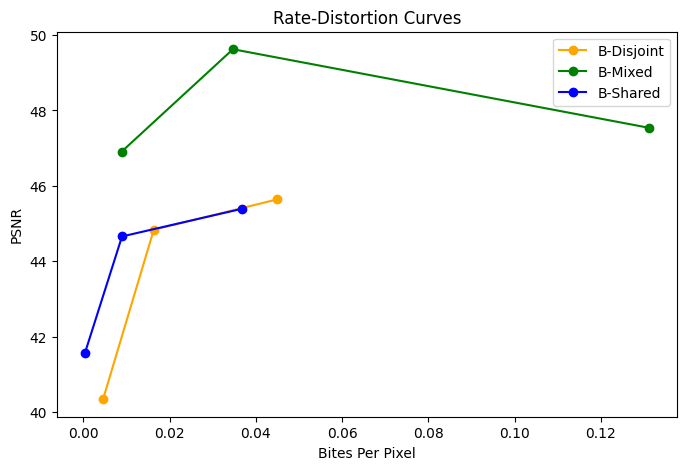

In [22]:
colors = ["orange", "green", "blue"]
plot_averaged_rate_distortion_curves(per_model_data_dictionary,
                                     per_model=True,
                                     markers=["o-" for _ in range(len(colors))],
                                     colors=colors)

## Adding Singles 

In [23]:
df_s = pd.read_csv("../results-singles-2023-07-04.csv")

# Filter out some values
df_s.drop(labels=["Name", "epoch", "Runtime"], axis=1, inplace=True)
df_s = df_s.sort_values(by=["architecture_type", "lmbda"])
df_s.architecture_type = [NAME_SHORT[v] for v in df_s.architecture_type.values]

df_s

,architecture_type,lmbda,tasks,val/compression_loss,val/depth_euclidean/compression_loss,val/depth_euclidean/mse,val/normal/compression_loss,val/normal/mse,val/rgb/compression_loss,val/rgb/mse,val/shared/compression_loss
9,Single,0.001,"[""depth_euclidean""]",0.016432,0.016432,16.157772,NaN,NaN,NaN,NaN,NaN
10,Single,0.001,"[""rgb""]",0.008439,NaN,NaN,NaN,NaN,0.008439,22.442747,NaN
11,Single,0.001,"[""normal""]",0.009478,NaN,NaN,0.009478,11.383947,NaN,NaN,NaN
6,Single,0.010,"[""rgb""]",0.029904,NaN,NaN,NaN,NaN,0.029904,10.838926,NaN
7,Single,0.010,"[""normal""]",0.028012,NaN,NaN,0.028012,7.246007,NaN,NaN,NaN
8,Single,0.010,"[""depth_euclidean""]",0.045150,0.045150,11.507100,NaN,NaN,NaN,NaN,NaN
3,Single,0.100,"[""normal""]",0.108967,NaN,NaN,0.108967,5.472238,NaN,NaN,NaN
4,Single,0.100,"[""rgb""]",0.106701,NaN,NaN,NaN,NaN,0.106701,8.532374,NaN
5,Single,0.100,"[""depth_euclidean""]",0.148056,0.148056,11.130475,NaN,NaN,NaN,NaN,NaN
0,Single,1.000,"[""normal""]",2.011233,NaN,NaN,2.011233,5.265038,NaN,NaN,NaN


In [24]:
df_s = df_s.groupby(by="lmbda")
df_s = df_s.sum(numeric_only=True)

df_s["architecture_type"] = "Single"
    
df_s["architecture_type"] = "Single"
df_s["lmbda"] = df_s.index
df_s = df_s[df_s["lmbda"] != 1]
df_s

,val/compression_loss,val/depth_euclidean/compression_loss,val/depth_euclidean/mse,val/normal/compression_loss,val/normal/mse,val/rgb/compression_loss,val/rgb/mse,val/shared/compression_loss,architecture_type,lmbda
lmbda,,,,,,,,,,
0.001,0.034348,0.016432,16.157772,0.009478,11.383947,0.008439,22.442747,0.0,Single,0.001
0.010,0.103066,0.045150,11.507100,0.028012,7.246007,0.029904,10.838926,0.0,Single,0.010
0.100,0.363723,0.148056,11.130475,0.108967,5.472238,0.106701,8.532374,0.0,Single,0.100


In [25]:
per_model_data_dictionary_s = make_data_dictionary(df_s)

per_model_data_dictionary.update(per_model_data_dictionary_s)

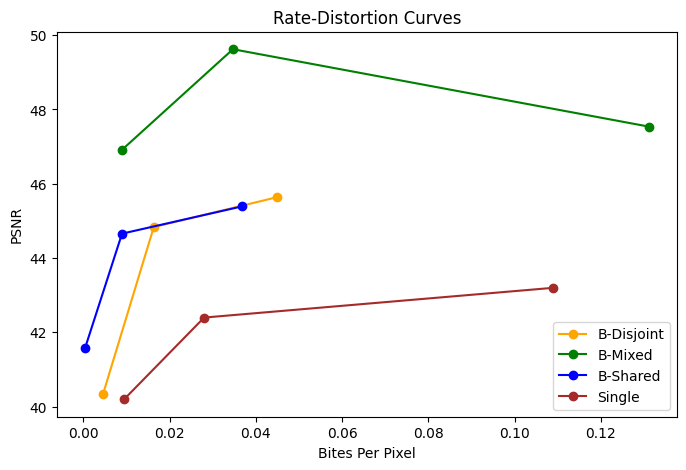

In [26]:
colors += ["brown"]
plot_averaged_rate_distortion_curves(per_model_data_dictionary,
                                     per_model=True,
                                     markers=["o-" for _ in range(10)],
                                     colors=colors)

## Adding pretrained model and JPEG

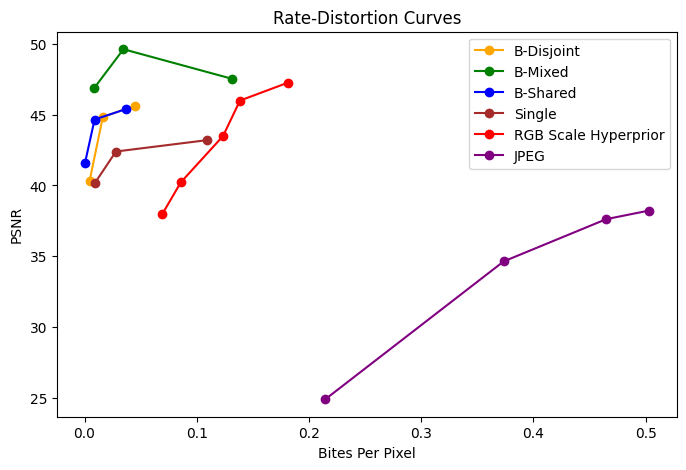

In [27]:
colors += ["red", "purple"]

per_model_data_dictionary["RGB Scale Hyperprior"] = pretr_ans
per_model_data_dictionary["JPEG"] = jpeg_ans
plot_averaged_rate_distortion_curves(per_model_data_dictionary,
                                     per_model=True,
                                     markers=["o-" for _ in range(10)],
                                     colors=colors)

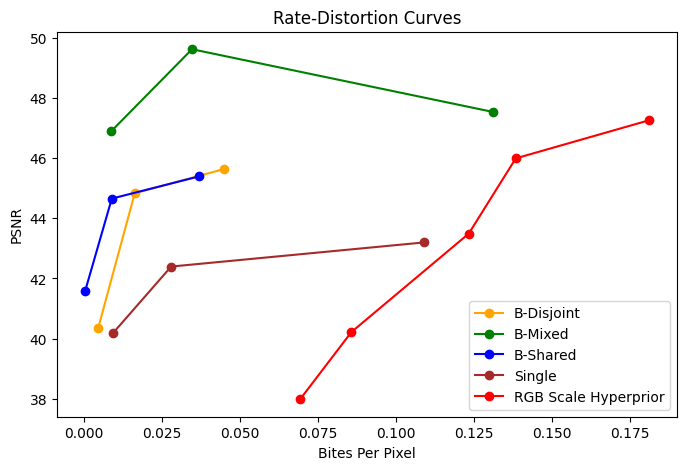

In [28]:
del per_model_data_dictionary["JPEG"]
colors = colors[:-1]

plot_averaged_rate_distortion_curves(per_model_data_dictionary,
                                     per_model=True,
                                     markers=["o-" for _ in range(10)],
                                     colors=colors)

## Adding the unbalanced models

In [29]:
df_n = pd.read_csv("../results-no-balance_2023-06-26.csv")

# Filter out some values
df_n = df_n[df_n["tasks"] == "[\"rgb\",\"depth_euclidean\",\"normal\"]"]
df_n.drop(labels=["Name", "epoch", "Runtime"], axis=1, inplace=True)
df_n = df_n.sort_values(by=["architecture_type", "lmbda"])
df_n.architecture_type = ["N-" + NAME_SHORT[v] for v in df_n.architecture_type.values]

df_n

,State,architecture_type,trainer/global_step,tasks,lmbda,val/rec_loss,val/compression_loss,val/rgb/mse,val/rgb/compression_loss,val/depth_euclidean/mse,val/depth_euclidean/compression_loss,val/normal/mse,val/normal/compression_loss,val/shared/compression_loss,train/rec_loss
17,finished,N-Disjoint,1720399,"[""rgb"",""depth_euclidean"",""normal""]",0.001,19.996975,0.012065,11.610521,0.013927,3.166125,0.011097,5.220325,0.012561,NaN,12.682950
11,finished,N-Disjoint,1720399,"[""rgb"",""depth_euclidean"",""normal""]",0.010,15.147106,0.034825,9.421438,0.039751,2.090362,0.032169,3.635309,0.033831,NaN,9.196287
5,finished,N-Disjoint,1720399,"[""rgb"",""depth_euclidean"",""normal""]",0.100,13.713889,0.098280,8.171432,0.102044,1.944638,0.099478,3.597819,0.094724,NaN,8.005946
16,finished,N-Mixed,781999,"[""rgb"",""depth_euclidean"",""normal""]",0.001,9.954443,0.006966,5.974905,0.021413,1.018917,0.021413,2.960620,0.021413,NaN,6.078275
10,crashed,N-Mixed,495049,"[""rgb"",""depth_euclidean"",""normal""]",0.010,5.857295,0.021935,3.584926,0.066434,0.576626,0.066434,1.695743,0.066434,NaN,5.045147
4,finished,N-Mixed,1329399,"[""rgb"",""depth_euclidean"",""normal""]",0.100,4.096419,0.063249,2.446866,0.190567,0.414695,0.190567,1.234859,0.190567,NaN,2.270500
15,crashed,N-Shared,1681349,"[""rgb"",""depth_euclidean"",""normal""]",0.001,19.140553,0.009463,11.552597,0.008976,2.577146,0.001462,5.010808,0.004826,0.004925,19.050505
9,crashed,N-Shared,1679699,"[""rgb"",""depth_euclidean"",""normal""]",0.010,14.668520,0.030484,9.070323,0.031167,2.036439,0.014146,3.561760,0.027603,0.006760,16.070412
3,crashed,N-Shared,1695376,"[""rgb"",""depth_euclidean"",""normal""]",0.100,13.298782,0.092339,8.368423,0.077174,1.632467,0.059812,3.297891,0.073096,0.022867,13.550200


In [30]:
per_model_data_dictionary_n = make_data_dictionary(df_n)

per_model_data_dictionary.update(per_model_data_dictionary_n)

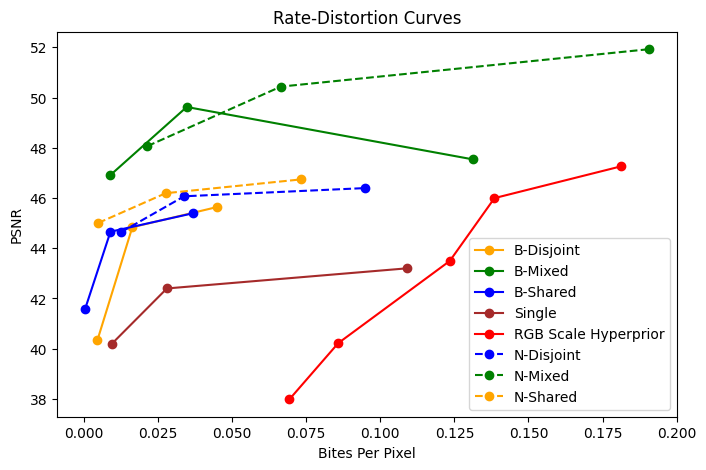

In [31]:
colors += ["blue", "green", "orange", "red"]

plot_averaged_rate_distortion_curves(per_model_data_dictionary, 
                                     per_model=True,
                                     markers=["o-" for _ in range(5)] + ["o--" for _ in range(3)],
                                     colors=colors)

## 2. RD Curves across tasks 

In [32]:
per_model_data_dictionary["JPEG"] = jpeg_ans

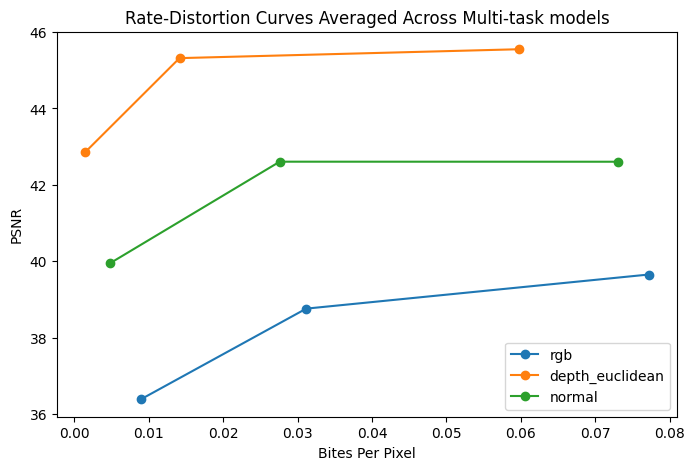

In [33]:
per_task_data_dictionary = {}

for model, task_dict in per_model_data_dictionary.items():
    if model in ("JPEG", "RGB Scale Hyperprior"):
        continue 
        
    for task, values_dict in task_dict.items():
        
        if task not in per_task_data_dictionary.keys():
            per_task_data_dictionary[task] = {}
            
        per_task_data_dictionary[task][model] = per_model_data_dictionary[model][task]
        
plot_averaged_rate_distortion_curves(per_task_data_dictionary, 
                                     per_model=False, 
                                     plot_title="Rate-Distortion Curves Averaged Across Multi-task models")

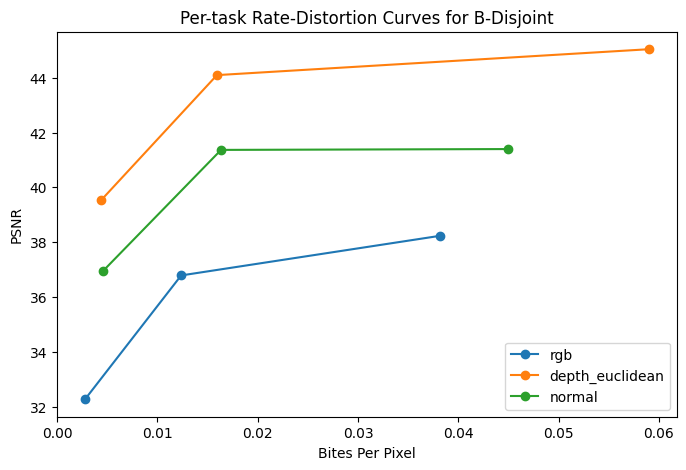

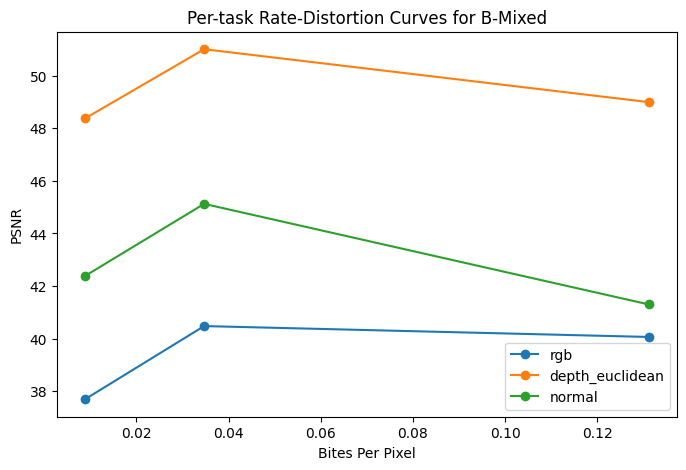

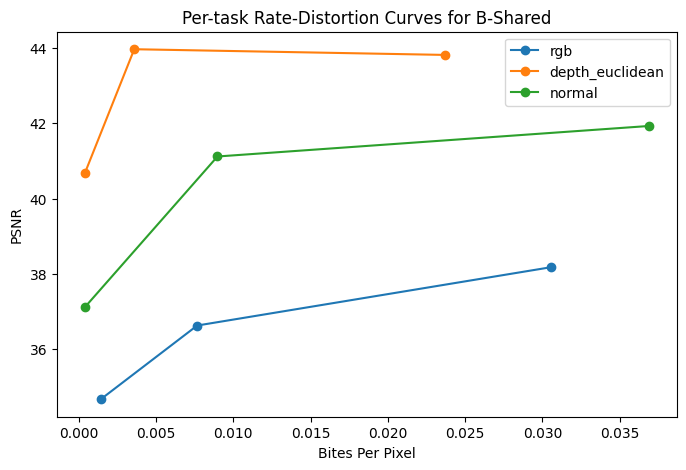

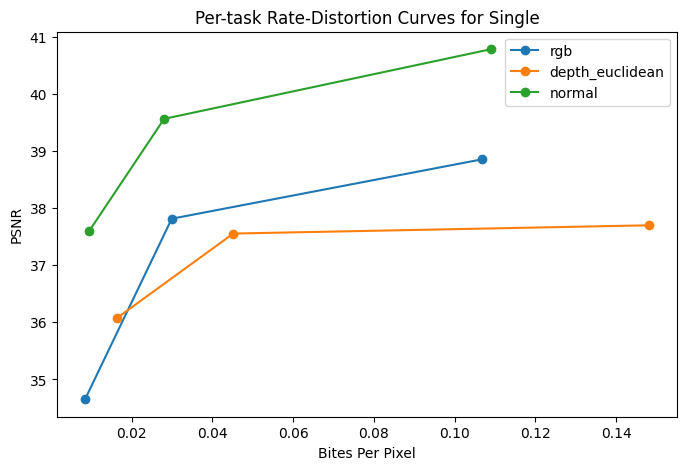

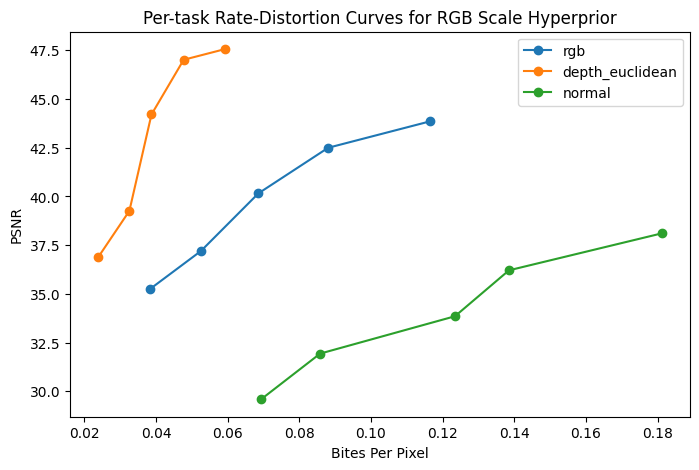

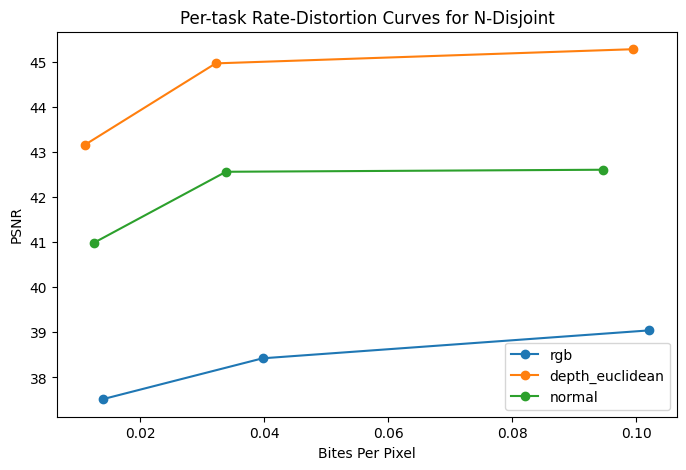

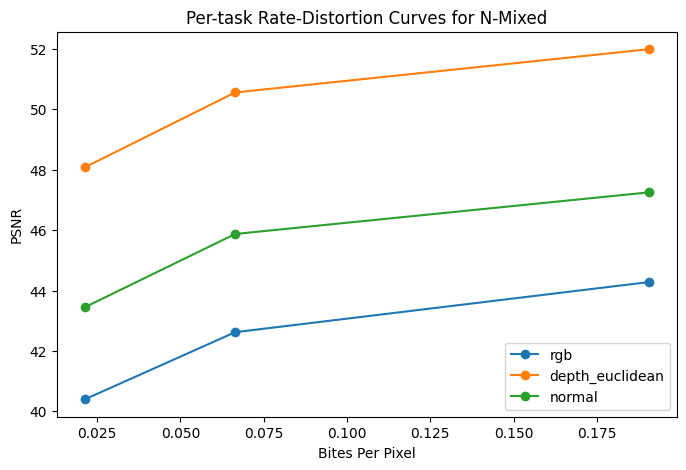

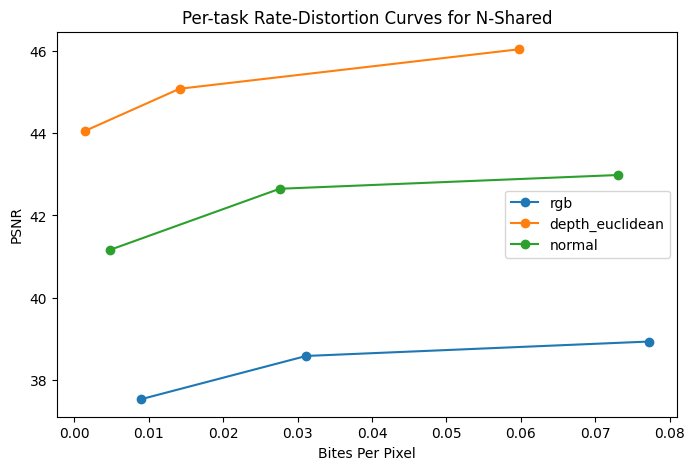

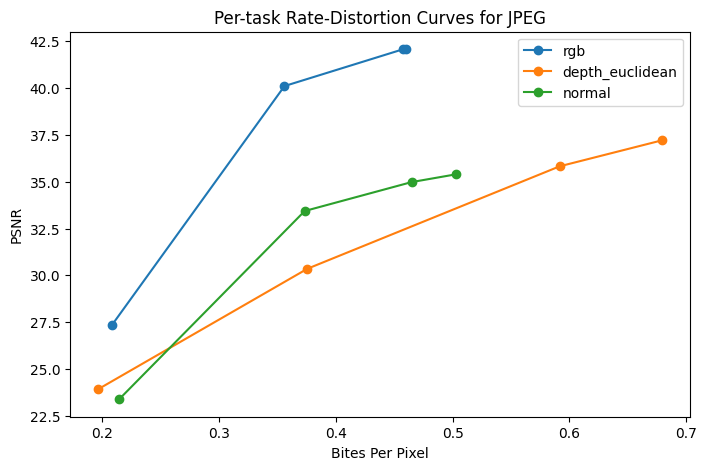

In [34]:
for model in per_model_data_dictionary.keys():
    
    per_task_data_dictionary = {}
    
    for task, values_dict in per_model_data_dictionary[model].items():
        per_task_data_dictionary[task] = {}
        per_task_data_dictionary[task][model] = per_model_data_dictionary[model][task]

    plot_averaged_rate_distortion_curves(per_task_data_dictionary, 
                                         per_model=False,
                                         plot_title=f"Per-task Rate-Distortion Curves for {model}")

### Now same thing but for singles

In [64]:
df = pd.read_csv("../results-singles-2023-07-04.csv")

# Filter out some values
df.drop(labels=["Name", "epoch", "Runtime"], axis=1, inplace=True)
df = df.sort_values(by=["tasks", "lmbda"])

df

,architecture_type,lmbda,tasks,val/compression_loss,val/depth_euclidean/compression_loss,val/depth_euclidean/mse,val/normal/compression_loss,val/normal/mse,val/rgb/compression_loss,val/rgb/mse,val/shared/compression_loss
9,SingleTaskCompressor,0.001,"[""depth_euclidean""]",0.016432,0.016432,16.157772,NaN,NaN,NaN,NaN,NaN
8,SingleTaskCompressor,0.010,"[""depth_euclidean""]",0.045150,0.045150,11.507100,NaN,NaN,NaN,NaN,NaN
5,SingleTaskCompressor,0.100,"[""depth_euclidean""]",0.148056,0.148056,11.130475,NaN,NaN,NaN,NaN,NaN
2,SingleTaskCompressor,1.000,"[""depth_euclidean""]",1.604821,1.604821,10.983914,NaN,NaN,NaN,NaN,NaN
11,SingleTaskCompressor,0.001,"[""normal""]",0.009478,NaN,NaN,0.009478,11.383947,NaN,NaN,NaN
7,SingleTaskCompressor,0.010,"[""normal""]",0.028012,NaN,NaN,0.028012,7.246007,NaN,NaN,NaN
3,SingleTaskCompressor,0.100,"[""normal""]",0.108967,NaN,NaN,0.108967,5.472238,NaN,NaN,NaN
0,SingleTaskCompressor,1.000,"[""normal""]",2.011233,NaN,NaN,2.011233,5.265038,NaN,NaN,NaN
10,SingleTaskCompressor,0.001,"[""rgb""]",0.008439,NaN,NaN,NaN,NaN,0.008439,22.442747,NaN
6,SingleTaskCompressor,0.010,"[""rgb""]",0.029904,NaN,NaN,NaN,NaN,0.029904,10.838926,NaN


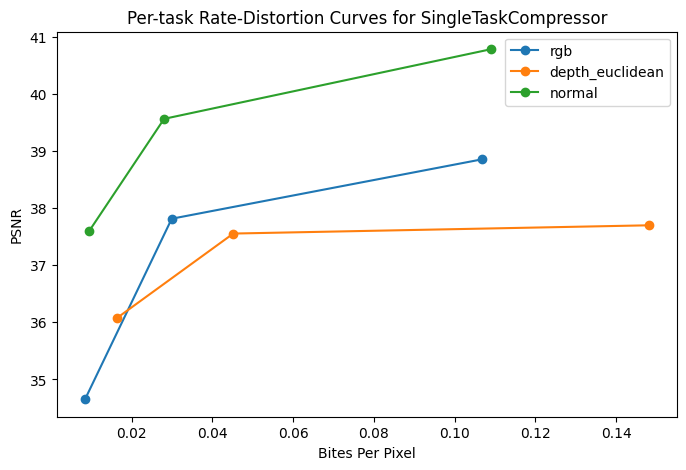

In [65]:
per_task_data_dictionary = {}
per_model_data_dictionary = make_data_dictionary(df[df.lmbda != 1])

for model in per_model_data_dictionary.keys():
    for task in per_model_data_dictionary[model].keys():
        per_task_data_dictionary[task] = {}
        per_task_data_dictionary[task][model] = per_model_data_dictionary[model][task]

plot_averaged_rate_distortion_curves(per_task_data_dictionary, 
                                     per_model=False,
                                     plot_title=f"Per-task Rate-Distortion Curves for {model}")

---

### Let's see how is the memmory disitributed by classes

In [66]:
pl.seed_everything(21)

ckpt_params = torch.load("../model-4-0001-v10-balance.ckpt", map_location="cpu")

# model_type = models.MultiTaskMixedLatentCompressor
model_type = models.MultiTaskSharedLatentCompressor
# model_type = models.MultiTaskDisjointLatentCompressor

compressor = model_type(**ckpt_params["hyper_parameters"]).eval()
compressor.load_state_dict(ckpt_params["state_dict"])
compressor.update_bottleneck_values()

Global seed set to 21


True

In [67]:
compressed_data, bytes, likelihoods = compressor.compress(batch, print_info=True)

Number of actual bytes in a string is: 4780, which gives a BPP = 0.00
Estimated BPP (compression loss) is: 0.00


In [68]:
num_pixels = 256 * 256
y_likelihoods = likelihoods["y"]
z_likelihoods = likelihoods["z"]

channel_bpps = np.array([torch.log(y_likelihoods[:, c]).sum().item() / (-math.log(2) * num_pixels * len(batch["rgb"]))
                for c in range(y_likelihoods.shape[1])])

94% of z's are 1

In [69]:
(z_likelihoods > 0.99).sum()/torch.prod(torch.tensor(z_likelihoods.shape)) * 100

tensor(94.4444)

In [70]:
(y_likelihoods > 0.99).sum()/torch.prod(torch.tensor(y_likelihoods.shape)) * 100

tensor(96.4792)

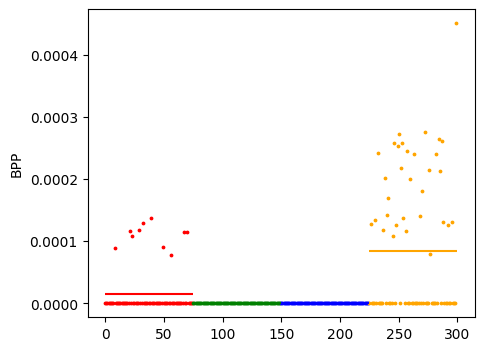

In [72]:
plot_by_task(channel_bpps, TASK_CHANNELS["shared"], plot="scatter")

# Understanding the shared latent

## Swaping latents of two samples

Here we take two sets of images (2 x 3) and forward them through the encoder part. After that we take the shared part of one image and concatenate it instead of the shared part of the second set of images and look at the reconstrucitons.

In [11]:
pl.seed_everything(21)

# Load the shared compressor
compressor_shared = load_compressor("../model-4-0001-v10-balance.ckpt", models.MultiTaskSharedLatentCompressor)
# Load the disjoint compressor
compressor_disjoint = load_compressor("../model-3-0001-v10-balance.ckpt", models.MultiTaskDisjointLatentCompressor)

Global seed set to 21


In [12]:
def get_latents(batch, model):
    """
    :returns: latents, likelihoods
    """
    stacked_t = model.forward_input_heads(batch)
    compressor_outputs = model.model["compressor"](stacked_t)
    
    return compressor_outputs["x_hat"], compressor_outputs["likelihoods"]

In [13]:
SAMPLE_1 = 6
SAMPLE_2 = 7

input_1 = {task: tensor[SAMPLE_1].unsqueeze(0) for task, tensor in batch.items()}
input_2 = {task: tensor[SAMPLE_2].unsqueeze(0) for task, tensor in batch.items()}

batch_latents, batch_likelihoods = get_latents(batch, compressor_shared)
latent_average = batch_latents.mean(dim=0)

In [14]:
latents_1, likelihoods_1 = get_latents(input_1, compressor_shared)
latents_2, likelihoods_2 = get_latents(input_2, compressor_shared)

likelihoods_1 = likelihoods_1["y"]
likelihoods_2 = likelihoods_2["y"]

latents_3 = deepcopy(latents_1.detach())
latents_3[:, -75:] = latents_2[:, -75:]
latents_4 = deepcopy(latents_2.detach())
latents_4[:, -75:] = latents_1[:, -75:]

likelihoods_3 = deepcopy(likelihoods_1.detach())
likelihoods_3[:, -75:] = likelihoods_2[:, -75:]
likelihoods_4 = deepcopy(likelihoods_2.detach())
likelihoods_4[:, -75:] = likelihoods_1[:, -75:]

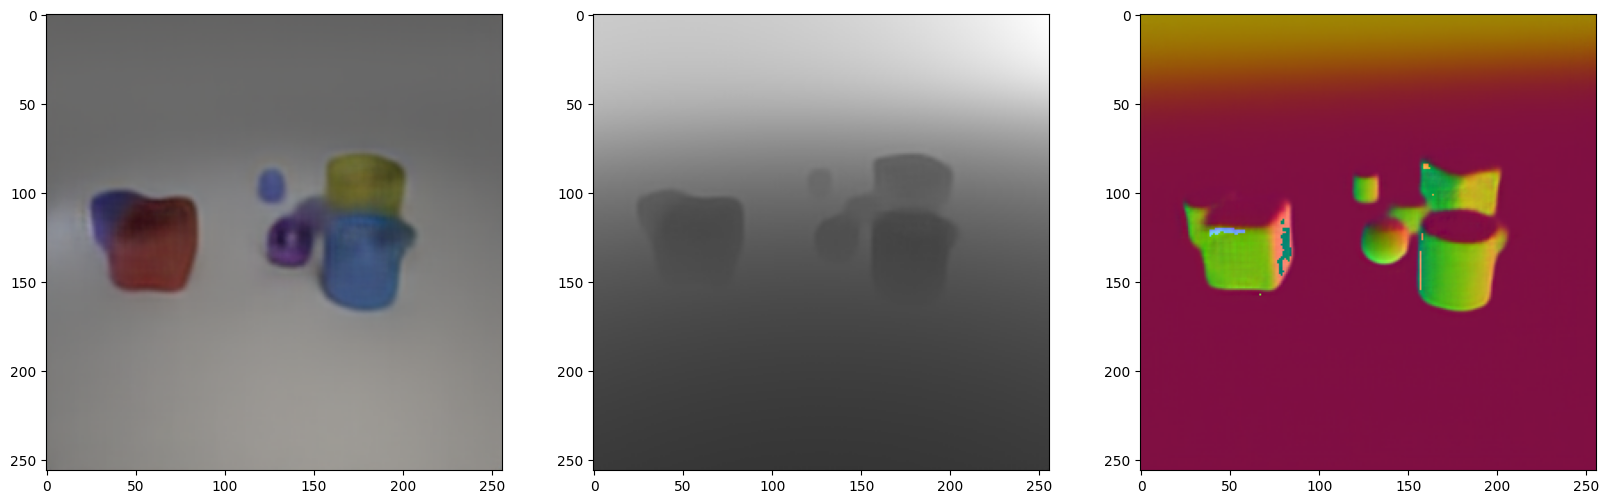

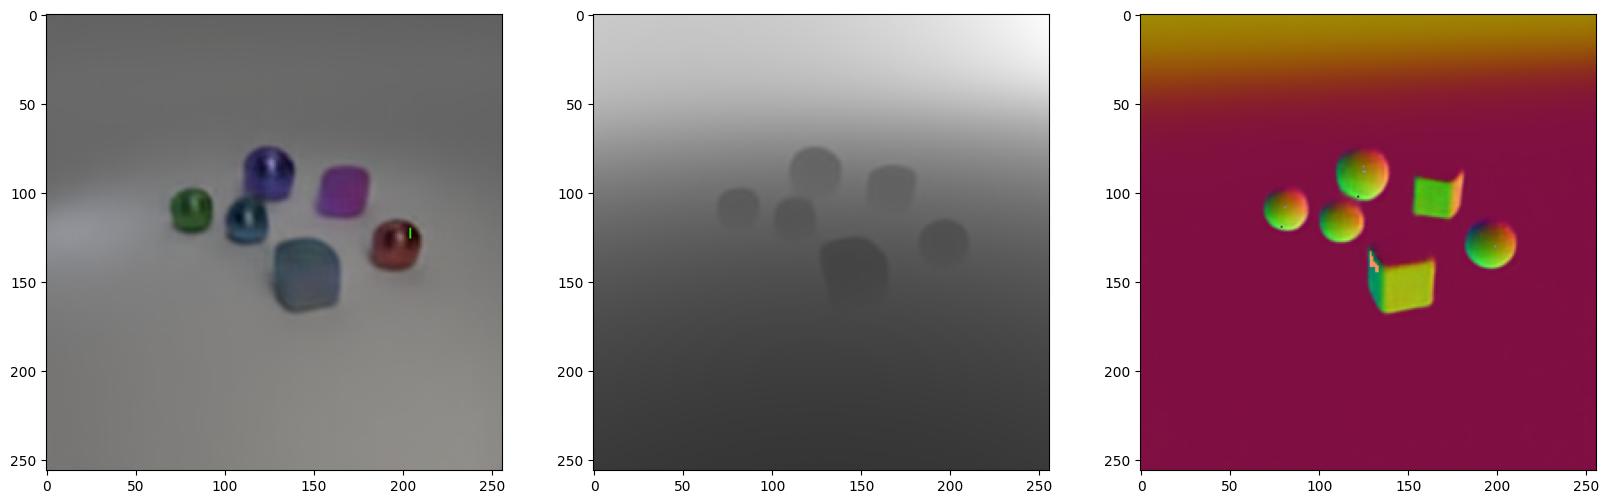

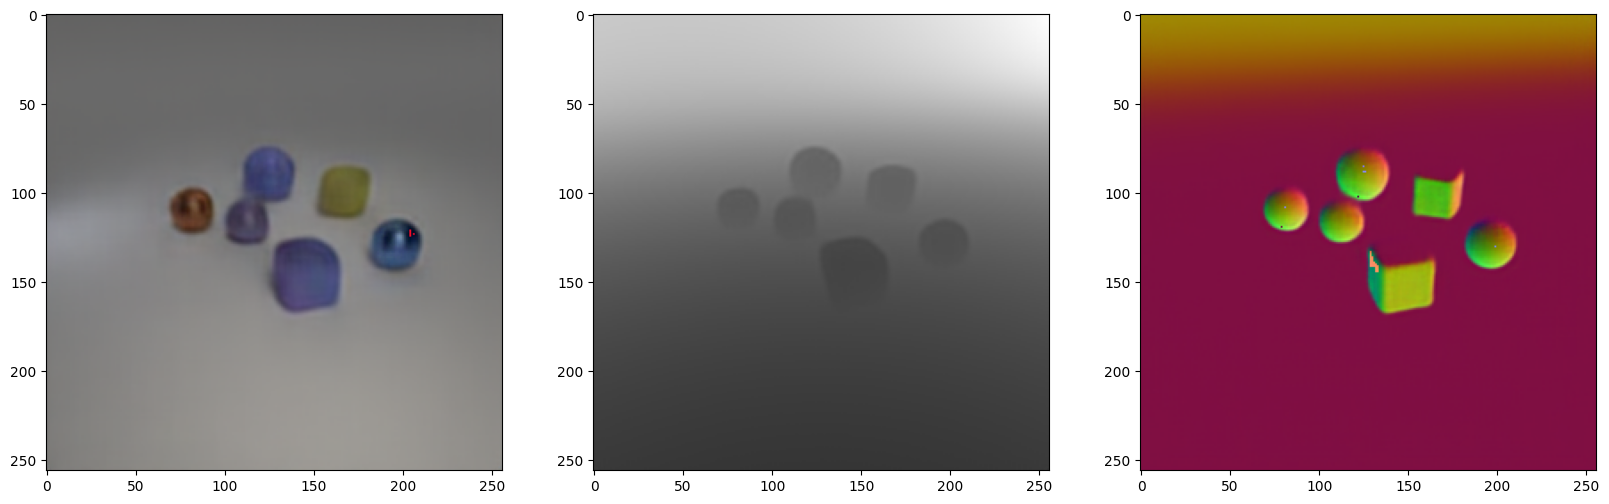

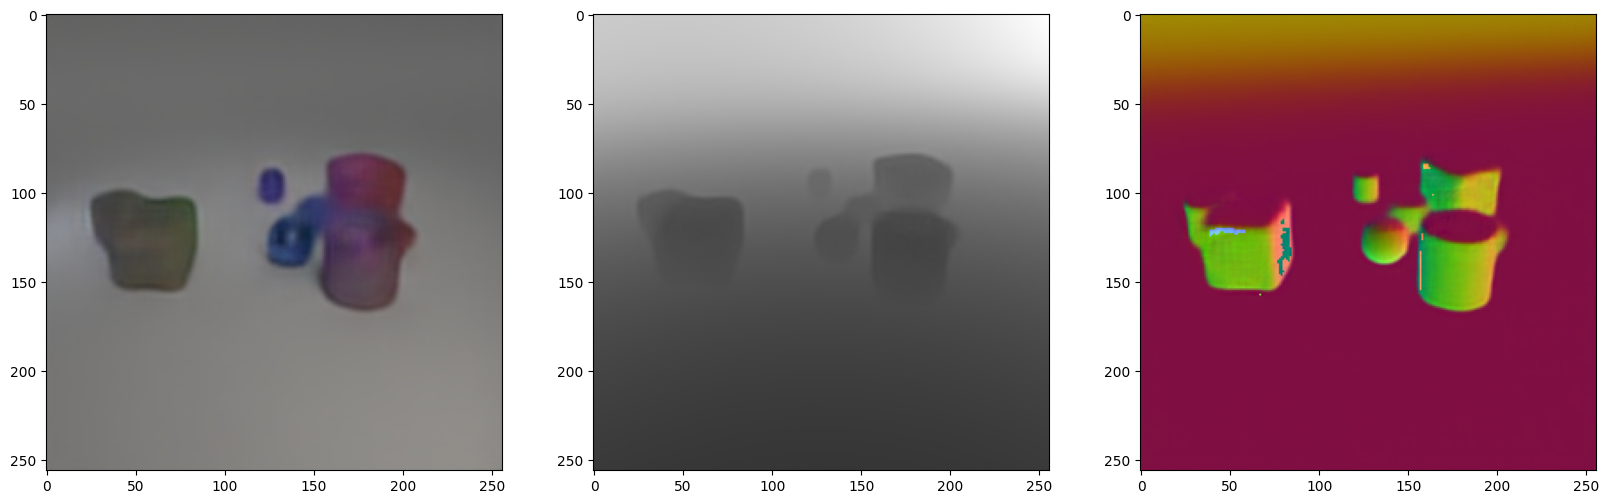

In [15]:
for lat in (latents_1, latents_2, latents_3, latents_4):
    images = [compressor_shared.forward_output_heads(lat)[task].squeeze().cpu() for task in batch.keys()]
    images[1] = (images[1]/images[1].max()).repeat(3, 1, 1)

    utils.show_images(images)

In [16]:
torch.allclose(latents_1[0, 75: 150], torch.zeros_like(latents_1[0, 75: 150]))

True

Total: 0.035


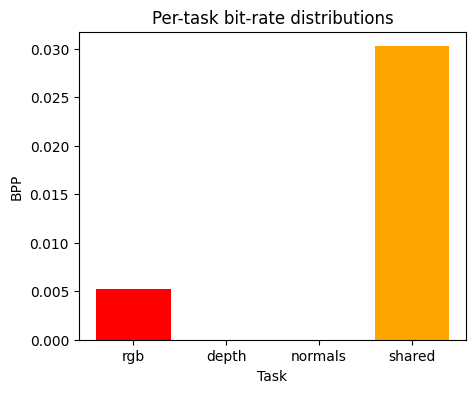

Total: 0.027


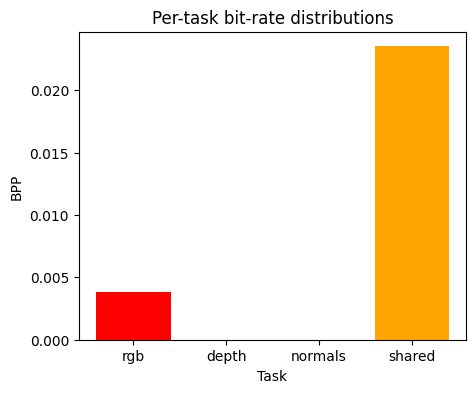

Total: 0.029


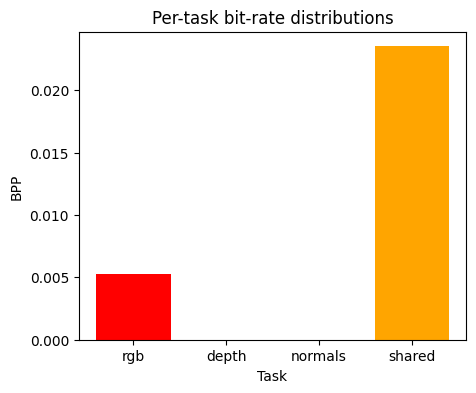

Total: 0.034


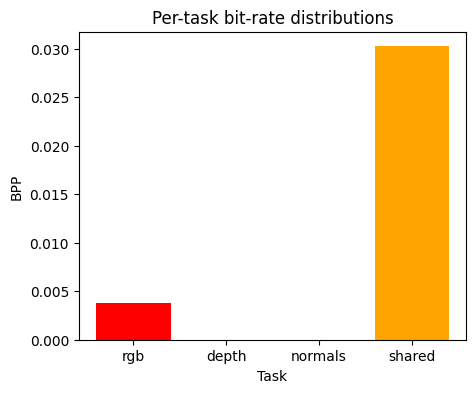

In [17]:
for like in (likelihoods_1,
             likelihoods_2, 
             likelihoods_3,
             likelihoods_4
            ):
    # computing per-channel BPPs
    bpps = [compute_bpp(l, NUM_PIXELS) for l in like.detach().squeeze(0)]
    print(f"Total: {sum(bpps):.3f}")
    plot_by_task(bpps, TASK_CHANNELS["shared"], plot="bar")

Same samples but for the disjoint model

Total: 0.050


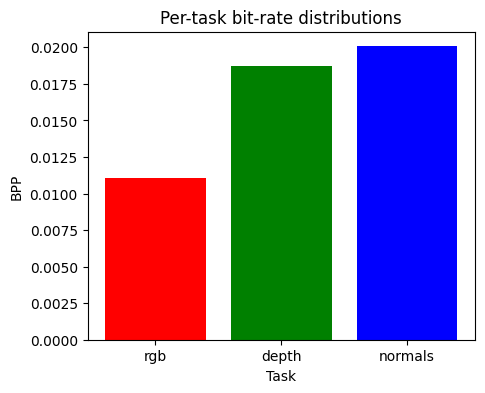

Total: 0.041


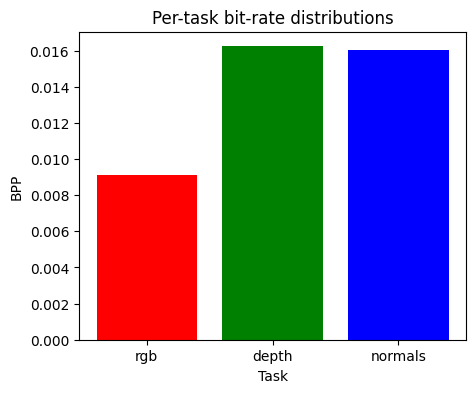

In [18]:
_, likelihoods_disj_1 = get_latents(input_1, compressor_disjoint)
_, likelihoods_disj_2 = get_latents(input_2, compressor_disjoint)

for like in (likelihoods_disj_1, likelihoods_disj_2):
    bpps = [compute_bpp(L, NUM_PIXELS) for L in like["y"].detach().squeeze(0)]
    print(f"Total: {sum(bpps):.3f}")
    plot_by_task(bpps, TASK_CHANNELS["disjoint"], plot="bar")

## Using an averaged shared part

In [19]:
batch_latents, batch_likelihoods = get_latents(batch, compressor_shared)
batch_latents.shape

torch.Size([64, 300, 4, 4])

In [20]:
latent_average = batch_latents.mean(dim=0)
latents_5 = deepcopy(latents_1.detach())
latents_5[:, -75:] = latent_average[-75:]

latents_6 = deepcopy(latents_2.detach())
latents_6[:, -75:] = latent_average[-75:]

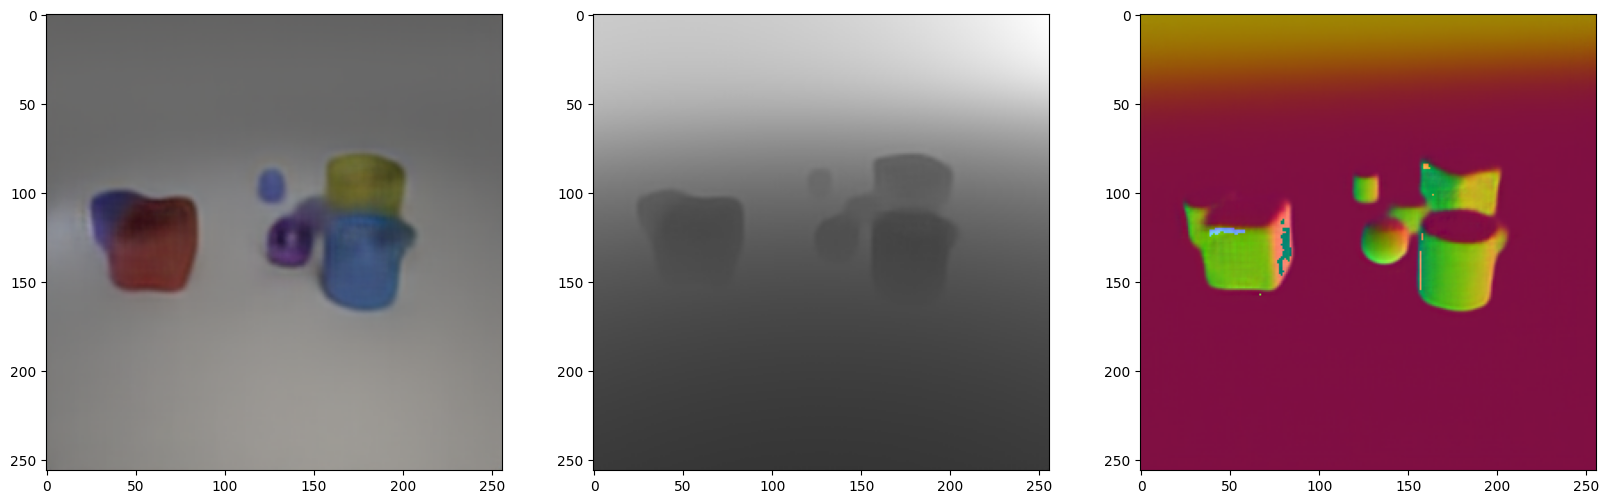

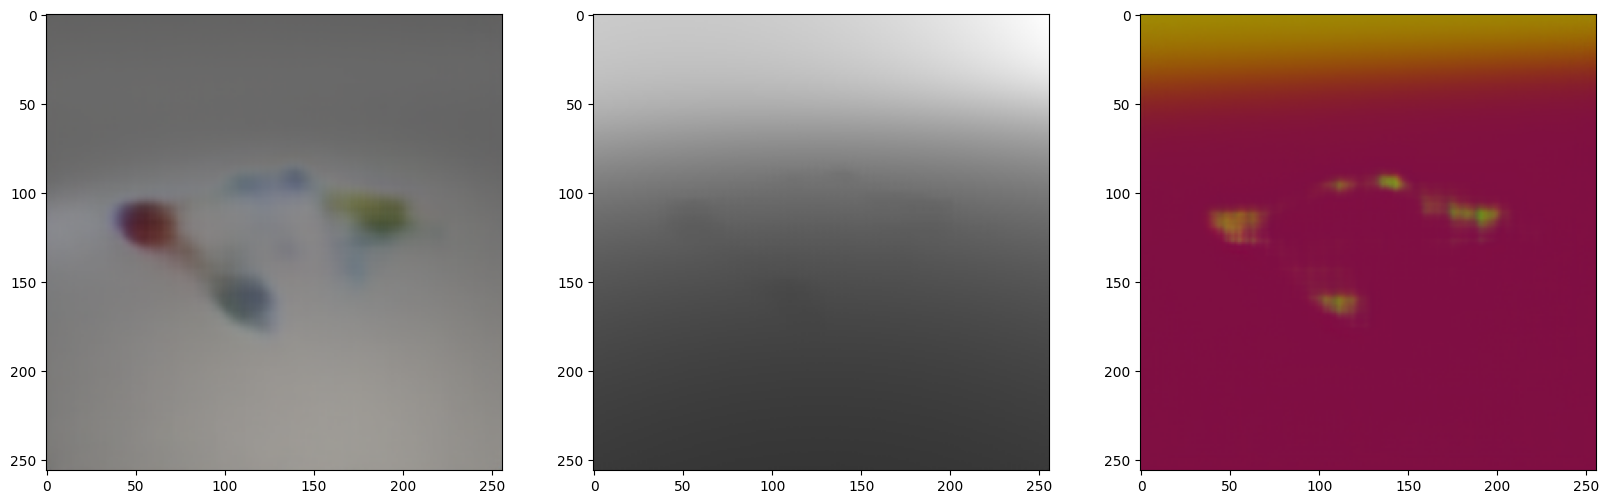

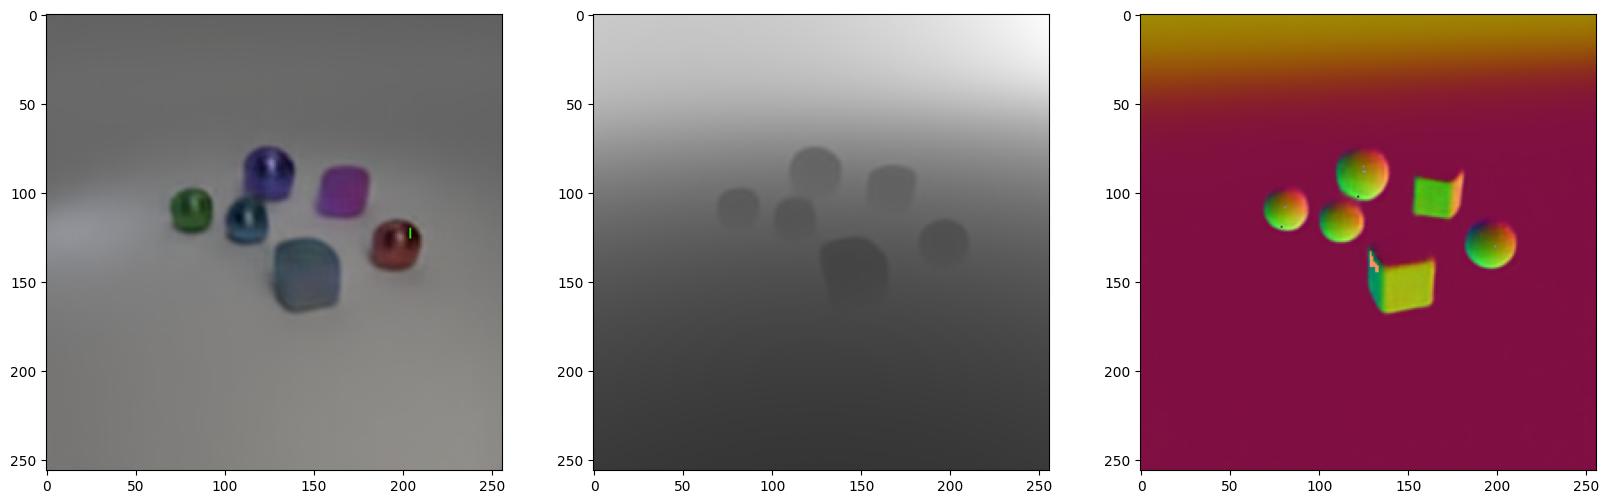

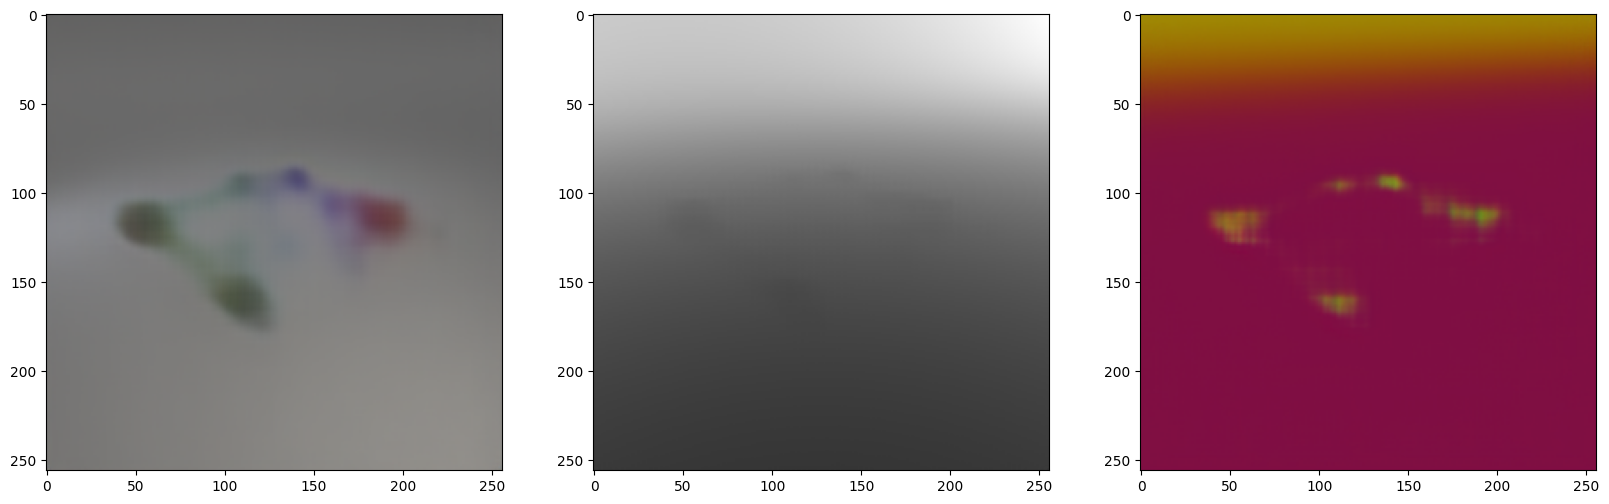

In [21]:
for lat in (latents_1, latents_5, latents_2, latents_6):
    images = [compressor_shared.forward_output_heads(lat)[task].squeeze().cpu() for task in batch.keys()]
    images[1] = (images[1]/images[1].max()).repeat(3, 1, 1)

    utils.show_images(images)

---

## What is stored in the shared latents?

Here I am trying to understand whether the channels in the shared latent are indeed "shared" (meaning they store information useful for all tasks). 

To test for this, we will set each of the shared latent channel values to the average of that channel and see what changes in the reconstruction. We will also compute the change in each task's performance metric.

1. Change latent channel's value to the average for that channel.
2. For each task - get new reconstructions
3. For each task - get MSE of the new reconstruction against the target
4. For each task - divide the new MSE over the original MSEs.

As output we will get three arrays of values for each channel.

- The greater is the error after changing the value - the more important is that channel for the task.
- If for some channels all three values are big - then the channels contains shared information

In [23]:
from tqdm import tqdm

In [24]:
def channel_effect(model, batch, plot: bool):
    latents_batch, _ = get_latents(batch, model)
    
    errs = {task: [] for task in model.tasks}
    predictions_batch = model.forward_output_heads(latents_batch)
    mse_baseline = {task: mse(predictions_batch[task].detach(), batch[task]) for task in model.tasks}

    latent_average = latents_batch.mean(dim=0)
    preds = []
    for i in tqdm(range(-75, 0, 1)):
        lat = deepcopy(latents_batch.detach())
        lat[:, i] = latent_average[i]
        predictions = model.forward_output_heads(lat)

        for task in model.tasks:
            errs[task].append(mse(batch[task], predictions[task].detach()))

    if plot:
        for task in model.tasks:
            plt.scatter(range(len(errs[task])), errs[task], s=5, marker='x')
    
        plt.legend(model.tasks)
        plt.show()
    return mse_baseline, errs

In [25]:
path = "/Users/narekalvandan/Downloads/model-4-01.ckpt"
# path = "../model-4-0001-v10-balance.ckpt"
compressor_shared = load_compressor(path, 
                        models.MultiTaskSharedLatentCompressor,
                        map_location="cpu")

In [26]:
(mse_baseline, mse_channels) = channel_effect(compressor_shared, {k: v[:8] for k, v in batch.items()}, plot=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:28<00:00,  2.65it/s]


In [27]:
for t in TASKS:
    mse_channels[t] /= mse_baseline[t]

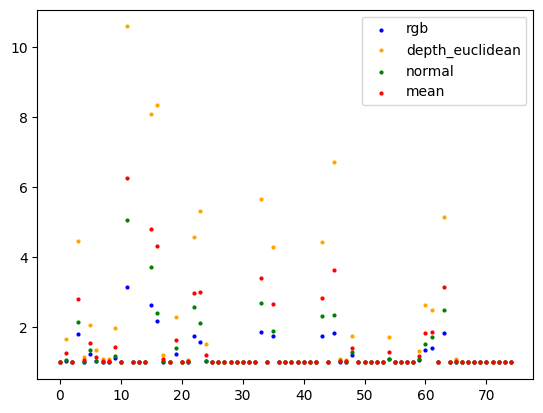

In [28]:
for c, t in zip(("blue", "orange", "green"), TASKS):
    plt.scatter(range(75), mse_channels[t], label=t, c=c, s=4)


mse_channels_mean = np.mean([mse_channels[t] for t in TASKS], axis=0)
plt.scatter(range(75), 
            mse_channels_mean, 
            label="mean",
            c="red",
            # alpha=0.5, 
            s=4)
plt.legend()
plt.show()

In [29]:
THRESHOLD = 1.01

non_zero_diff = (mse_channels_mean > THRESHOLD)
dnr = (mse_channels["depth_euclidean"] >= mse_channels["normal"]) & (mse_channels["normal"] >= mse_channels["rgb"])
drn = (mse_channels["depth_euclidean"] >= mse_channels["rgb"]) & (mse_channels["rgb"] >= mse_channels["normal"])

print("Above threshold:", non_zero_diff.sum() / len(dnr))
print("Out of those:")
print("d > n > r:", f"{(non_zero_diff & dnr).sum() / sum(non_zero_diff):.2f}")
print("d > r > n:", f"{(non_zero_diff & drn).sum() / sum(non_zero_diff):.2f}")

Above threshold: 0.4
Out of those:
d > n > r: 0.87
d > r > n: 0.13


## Visualize reconstruction differences

In [30]:
def image_difference(im1, im2, normalized=False):
    diff = abs(im1 - im2)
    if normalized:
        return (diff - diff.min()) / (diff.max() - diff.min())
    return diff

In [31]:
model = compressor_shared
channel_number = -75 + np.argmax(mse_channels["normal"])

latents_1, _ = get_latents(batch={k: v[channel_number].unsqueeze(0) for k, v in batch.items()},
                        model=compressor_shared)

# original predictions
images = model.forward_output_heads(latents_1)
images = [im.squeeze(0) for _, im in images.items()]
images[1] = (images[1]/images[1].max()).repeat(3, 1, 1)

# channel substituted predictions
temp = deepcopy(latents_1.detach())
temp[:, channel_number] = latent_average[channel_number]

images_sub = model.forward_output_heads(temp)
images_sub = [im.squeeze(0) for _, im in images_sub.items()]
images_sub[1] = (images_sub[1] / images_sub[1].max()).repeat(3, 1, 1)

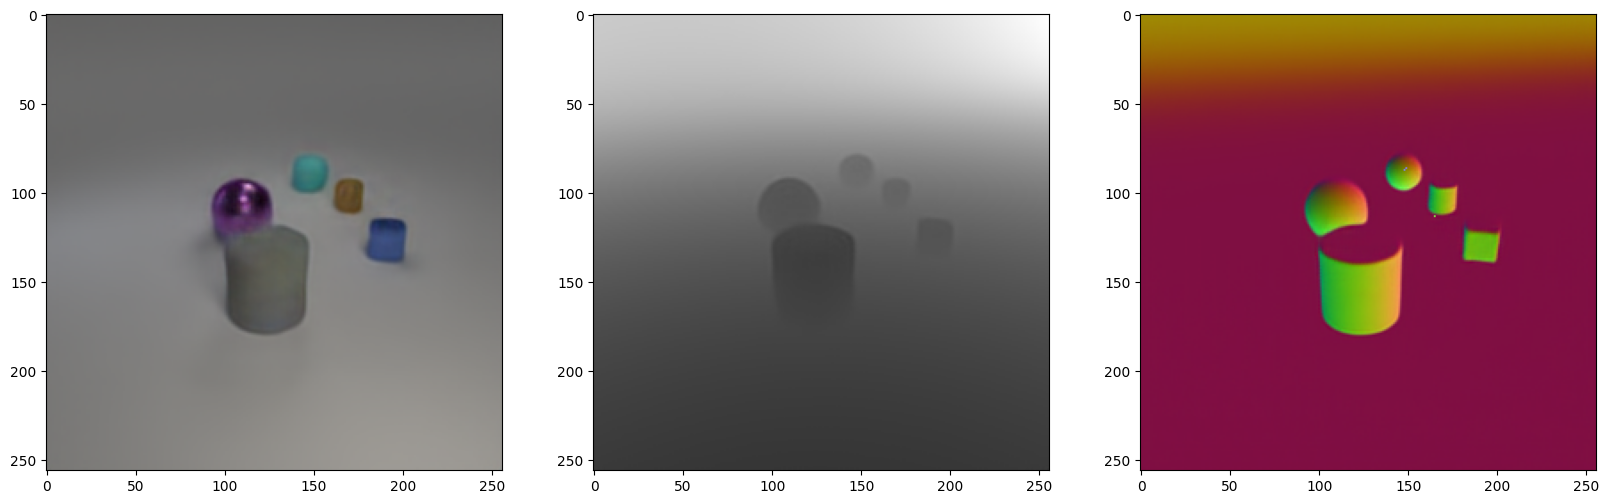

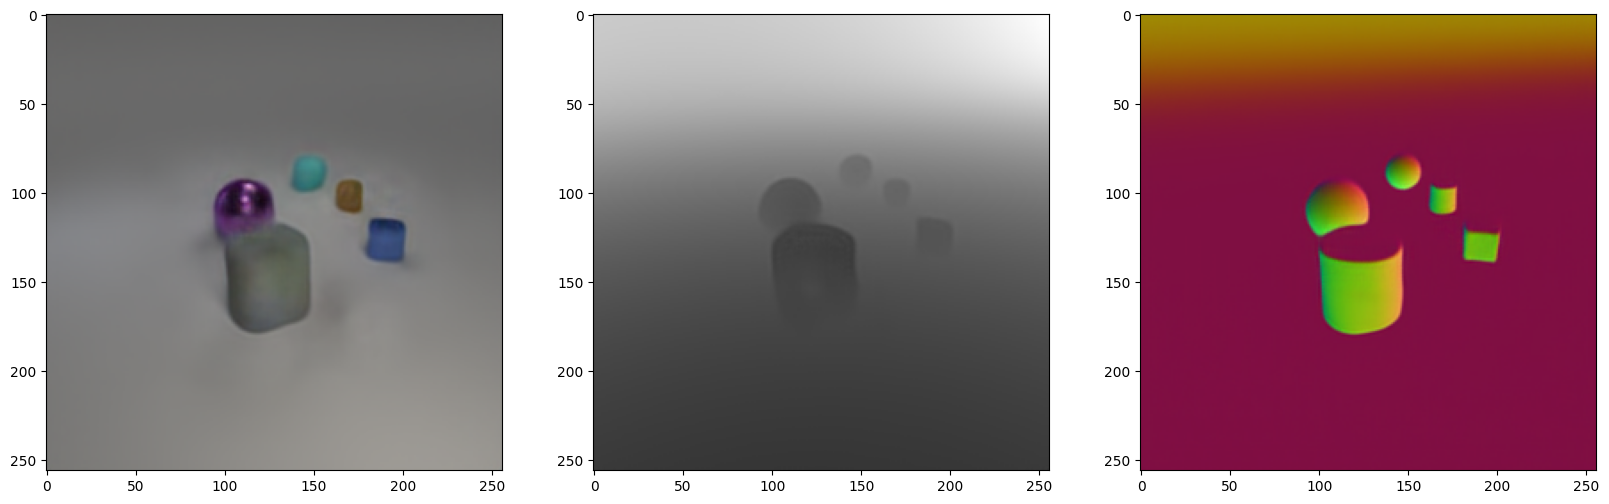

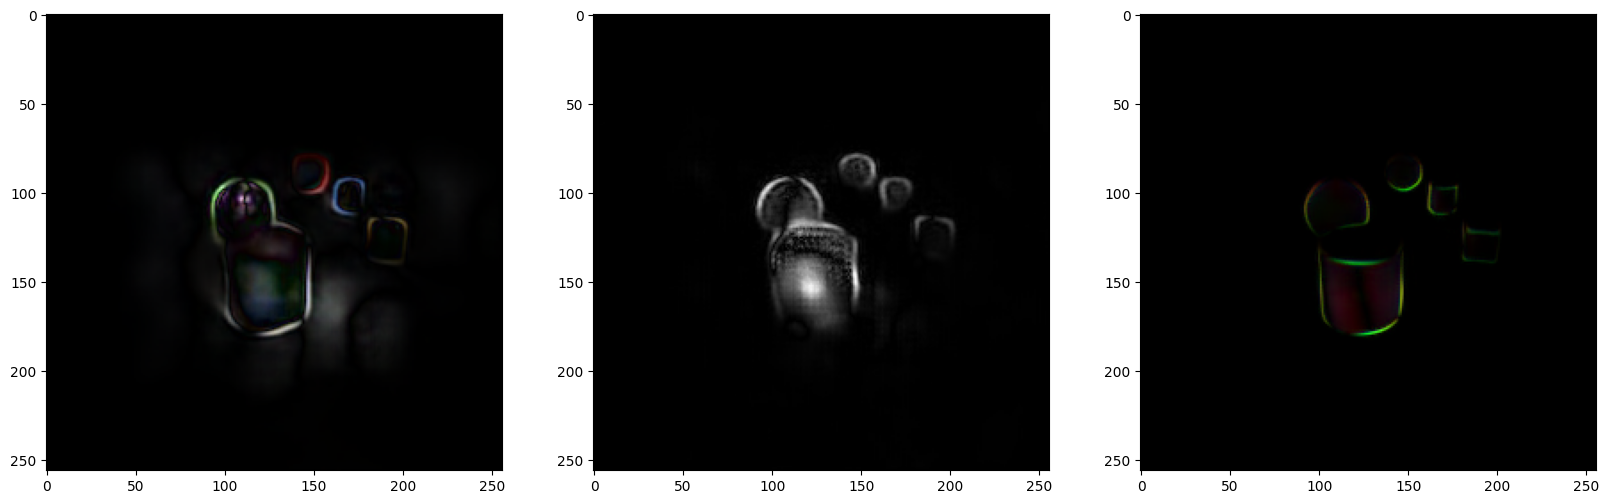

In [32]:
utils.show_images(images)
utils.show_images(images_sub)
utils.show_images([image_difference(images_sub[i], images[i], normalized=True) for i in range(len(images))])